## 5x - pySCENIC

### Repeating pySCENIC run 5x and merging the collective output

**Runs with pySCENIC_2 env**

1) Generate AUC matrix with all regulons  
2) Merge the results   
3) Export all the results, including AUC matrix data, experimental annotation and seurat tSNE dimensions to loom file for SCOPE  
4) Calculate the number of targets per chromosome, per regulon etc  
5) Continue with interpretation in the next notebook

In [2]:
import os
import glob
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from dask.diagnostics import ProgressBar

/data/leuven/320/vsc32023/miniconda/envs/pySCENIC_2/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [4]:
from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

In [5]:
from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

In [6]:
import seaborn as sns

In [7]:
cd /staging/leuven/stg_00041/Adrian/TALON_JANISZEWSKI_XCR2/

/lustre1/project/stg_00041/Adrian/TALON_JANISZEWSKI_XCR2


In [8]:
DATA_FOLDER="/staging/leuven/stg_00041/Adrian/TALON_JANISZEWSKI_XCR2/SCENIC/data_folder"
RESOURCES_FOLDER="/staging/leuven/stg_00041/Adrian/TALON_JANISZEWSKI_XCR2/SCENIC/resources_folder"
DATABASE_FOLDER = "/staging/leuven/stg_00041/Adrian/TALON_JANISZEWSKI_XCR2/SCENIC/database_folder"
SCHEDULER="123.122.8.24:8786"
DATABASES_GLOB = os.path.join(DATABASE_FOLDER, "mm10*.mc9nr.feather")
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.mgi-m0.001-o0.0.tbl")
MM_TFS_FNAME = os.path.join(RESOURCES_FOLDER, 'mm_mgi_tfs.txt')
#SC_EXP_FNAME = os.path.join(RESOURCES_FOLDER, "AJ_0065_counts_clean.csv")

In [9]:
# These are the output directories and file names. Change name for each run repeat

REGULONS_FNAME = os.path.join(DATA_FOLDER, "regulons_5.p")
MOTIFS_FNAME = os.path.join(DATA_FOLDER, "motifs_5.csv")

#### Load in the count matrix (import from .csv and standard structure, cells in columns and genes in rownames)

Transpose the matrix on import so that genes are in columns and cells in rownames

### Load in normalized count matrix if you want to run SCENIC on normalized data

In [8]:
exp_mtx = pd.read_csv(os.path.join(RESOURCES_FOLDER, "AJ_0065_seurat_normCounts.csv"), index_col=0, sep=',').T

In [9]:
exp_mtx.shape

(567, 26127)

In [10]:
exp_mtx.iloc[0:10,100:110]

,Gm37509,Sbspon,Gm7634,Rpl7,Rdh10,Stau2,Ube2w,Gm38342,Eloc,D030040B21Rik
Day_9_Xi_Mus_33,0.000000,0.865078,0.000000,1.359729,0.235379,0.0,0.000000,0.000000,0.113892,0.0
Day_10_Xi_Mus_25,0.000000,0.000000,0.000000,1.508699,0.000000,0.0,0.190081,0.000000,0.830362,0.0
Day_10_Xi_Mus_32,0.000000,0.000000,0.000000,1.390522,0.000000,0.0,0.486221,0.000000,0.695968,0.0
Day_9_Xi_Mus_27,0.000000,0.000000,0.000000,1.337175,0.000000,0.0,0.034501,0.000000,0.947654,0.0
Day_9_Xi_Mus_36,0.000000,0.000000,0.033718,1.390725,0.000000,0.0,0.437405,0.000000,0.600497,0.0
Day_10_Xi_Mus_30,0.000000,0.000000,0.000000,1.624838,0.000000,0.0,0.000000,0.000000,0.868837,0.0
Day_10_Xi_Mus_33,0.000000,0.000000,0.000000,1.433764,0.821092,0.0,0.046919,0.000000,0.439818,0.0
Day_9_Xi_Mus_32,0.000000,0.000000,0.000000,1.611634,0.641137,0.0,0.436931,0.000000,0.921215,0.0
Day_10_Xi_Mus_34,0.191005,0.000000,0.067804,1.883628,1.013009,0.0,0.247344,0.000000,0.701734,0.0
Day_10_Xi_Mus_28,0.000000,0.000000,0.000000,1.304691,0.339320,0.0,0.249041,0.058834,0.984535,0.0


#### Load in the list of Transcription Factors for Mus Musculus

In [11]:
tf_names = load_tf_names(MM_TFS_FNAME)

#### Load in the ranking databases

In [12]:
db_fnames = glob.glob(DATABASES_GLOB)
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs

[FeatherRankingDatabase(name="mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr"),
 FeatherRankingDatabase(name="mm10__refseq-r80__10kb_up_and_down_tss.mc9nr")]

### Phase I: Inference of co-expression modules

In [33]:
from distributed import Client, LocalCluster

In [34]:
# Run on one of the big nodes and don't increase the n_workers or threads per worker. 

local_cluster = LocalCluster(n_workers=8, threads_per_worker=1)
client = Client(local_cluster)

In the initial phase of the pySCENIC pipeline the single cell expression profiles are used to infer co-expression modules from.

Run GENIE3 or GRNBoost from arboreto to infer co-expression modules
The arboreto package is used for this phase of the pipeline.

In [35]:
adjacencies_5 = grnboost2(
    expression_data=exp_mtx,
    tf_names=tf_names,
    verbose=True,
    client_or_address=client)

preparing dask client
parsing input
creating dask graph


/data/leuven/320/vsc32023/miniconda/envs/pySCENIC/lib/python3.6/site-packages/arboreto/algo.py:214: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  expression_matrix = expression_data.as_matrix()


8 partitions
computing dask graph
not shutting down client, client was created externally
finished


In [40]:
adjacencies_5.head()

,TF,target,importance
1190,Foxh1,Kifc2,161.844956
1289,Hmga1,Hmga1b,112.688454
132,Cd59b,Cd59a,108.046850
1438,Rhox6,Rhox9,103.897554
492,Spr,Spr-ps1,99.344646


In [51]:
# Building adjacencies takes a good while, so it's a good idea to save it

adjacencies_5.to_csv("SCENIC/adjacencies_5_norm.csv")

In [39]:
adjacencies_5 = pd.read_csv('SCENIC/adjacencies_5_norm.csv', index_col=0)

EmptyDataError: No columns to parse from file

In [21]:
adjacencies_4.head()

,TF,target,importance
1438,Rhox6,Rhox9,132.788183
132,Cd59b,Cd59a,114.990839
1289,Hmga1,Hmga1b,104.267507
1190,Foxh1,Kifc2,96.521021
492,Spr,Spr-ps1,94.189386


#### Derive potential regulons from these co-expression modules

Regulons are derived from adjacencies based on three methods.

The first method to create the TF-modules is to select the best targets for each transcription factor:

Targets with importance > the 50th percentile.
Targets with importance > the 75th percentile
Targets with importance > the 90th percentile.
The second method is to select the top targets for a given TF:

Top 50 targets (targets with highest weight)
The alternative way to create the TF-modules is to select the best regulators for each gene (this is actually how GENIE3 internally works). Then, these targets can be assigned back to each TF to form the TF-modules. In this way we will create three more gene-sets:

Targets for which the TF is within its top 5 regulators
Targets for which the TF is within its top 10 regulators
Targets for which the TF is within its top 50 regulators
A distinction is made between modules which contain targets that are being activated and genes that are being repressed. Relationship between TF and its target, i.e. activator or repressor, is derived using the original expression profiles. The Pearson product-moment correlation coefficient is used to derive this information.

In addition, the transcription factor is added to the module and modules that have less than 20 genes are removed.

In [44]:
modules_5 = list(modules_from_adjacencies(adjacencies_5, exp_mtx))

### Phase II: Prune modules for targets with cis regulatory footprints (aka RcisTarget)

In [74]:
from distributed import Client, LocalCluster

In [49]:
local_cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(local_cluster)

In [50]:
# Calculate a list of enriched motifs and the corresponding target genes for all modules.
with ProgressBar():
    df = prune2df(dbs, modules_5, MOTIF_ANNOTATIONS_FNAME, client_or_address=client)

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:58142 remote=tcp://127.0.0.1:40701>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:39396 remote=tcp://127.0.0.1:33937>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:58146 remote=tcp://127.0.0.1:40701>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:39400 remote=tcp://127.0.0.1:33937>


In [54]:
regulons_5 = df2regulons(df)

In [56]:
df.to_csv(MOTIFS_FNAME)
with open(REGULONS_FNAME, "wb") as f:
    pickle.dump(regulons_5, f)

### Phase II-III: Generate regulons from 5 SCENIC runs combined

In [13]:
motifs1 = load_motifs(os.path.join(DATA_FOLDER, "motifs.csv"))
motifs2 = load_motifs(os.path.join(DATA_FOLDER, "motifs_2.csv"))
motifs3 = load_motifs(os.path.join(DATA_FOLDER, "motifs_3.csv"))
motifs4 = load_motifs(os.path.join(DATA_FOLDER, "motifs_4.csv"))
motifs5 = load_motifs(os.path.join(DATA_FOLDER, "motifs_5.csv"))

In [14]:
motifs1.head(n = 10)

Enrichment            \
                                                          NES       AUC   
TF     MotifID                                                            
Arid3a yetfasco__YEL009C_1363                        3.542587  0.056251   
       cisbp__M4625                                  3.181561  0.053718   
       homer__DATGASTCATHN_Atf3                      3.139206  0.053421   
       transfac_pro__M08926                          3.219714  0.053986   
       homer__ATGACTCATC_AP-1                        3.296861  0.054527   
       transfac_pro__M00926                          3.328459  0.054748   
Atf3   taipale_cyt_meth__JDP2_NRTGAYGTCAYN_FL_meth   3.243922  0.052503   
       taipale__JDP2_full_NATGACGTCAYN               3.533027  0.054458   
       taipale_cyt_meth__ATF2_NRTGAYGTMAYN_FL        3.009523  0.050918   
       transfac_public__M00178                       3.458108  0.053951   

                                                                          \
                                                   MotifSimilarityQvalue   
TF     MotifID                                                             
Arid3a yetfasco__YEL009C_1363                                   0.000998   
       cisbp__M4625                                             0.000757   
       homer__DATGASTCATHN_Atf3                                 0.000828   
       transfac_pro__M08926                                     0.000783   
       homer__ATGACTCATC_AP-1                                   0.000205   
       transfac_pro__M00926                                     0.000915   
Atf3   taipale_cyt_meth__JDP2_NRTGAYGTCAYN_FL_meth              0.000248   
       taipale__JDP2_full_NATGACGTCAYN                          0.000306   
       taipale_cyt_meth__ATF2_NRTGAYGTMAYN_FL                   0.000001   
       transfac_public__M00178                                  0.000120   

                                                                        \
                                                   OrthologousIdentity   
TF     MotifID                                                           
Arid3a yetfasco__YEL009C_1363                                 0.809444   
       cisbp__M4625                                           0.809444   
       homer__DATGASTCATHN_Atf3                               0.809444   
       transfac_pro__M08926                                   0.798669   
       homer__ATGACTCATC_AP-1                                 0.809444   
       transfac_pro__M00926                                   0.809444   
Atf3   taipale_cyt_meth__JDP2_NRTGAYGTCAYN_FL_meth            1.000000   
       taipale__JDP2_full_NATGACGTCAYN                        1.000000   
       taipale_cyt_meth__ATF2_NRTGAYGTMAYN_FL                 1.000000   
       transfac_public__M00178                                1.000000   

                                                                                                       \
                                                                                           Annotation   
TF     MotifID                                                                                          
Arid3a yetfasco__YEL009C_1363                       motif similar to dbcorrdb__ARID3A__ENCSR000EFY...   
       cisbp__M4625                                 motif similar to dbcorrdb__ARID3A__ENCSR000EFY...   
       homer__DATGASTCATHN_Atf3                     motif similar to dbcorrdb__ARID3A__ENCSR000EFY...   
       transfac_pro__M08926                         gene is orthologous to ENSG00000116017 in H. s...   
       homer__ATGACTCATC_AP-1                       motif similar to dbcorrdb__ARID3A__ENCSR000EFY...   
       transfac_pro__M00926                         motif similar to dbcorrdb__ARID3A__ENCSR000EFY...   
Atf3   taipale_cyt_meth__JDP2_NRTGAYGTCAYN_FL_meth  motif similar to transfac_pro__M00981 ('V$CREB...   
       taipale__JDP2_full_NATGACGTCAYN              gene is annotated for

In [84]:
motifs1.index.get_level_values('TF').unique()

Index(['Arid3a', 'Atf3', 'Atf6b', 'Bcl6', 'Bhlhe40', 'Bhlhe41', 'Bmyc',
       'Brca1', 'Cebpb', 'Creb3',
       ...
       'Tbx5', 'Tead2', 'Trps1', 'Zfp319', 'Creb5', 'Nfix', 'Sox21', 'Msx1',
       'Plagl1', 'Nfia'],
      dtype='object', name='TF', length=257)

In [85]:
motifs2.index.get_level_values('TF').unique()

Index(['Arid3a', 'Atf3', 'Atf6b', 'Bhlhe40', 'Bhlhe41', 'Brca1', 'Cebpb',
       'Creb3', 'Creb3l1', 'Dmbx1',
       ...
       'Usf1', 'Zfp362', 'Zfp467', 'Batf', 'Lhx2', 'Mycn', 'Nfil3', 'Zfp14',
       'Tbx5', 'Zic4'],
      dtype='object', name='TF', length=259)

In [45]:
motifs3.index.get_level_values('TF').unique()

Index(['Alx3', 'Arid3a', 'Atf3', 'Atf4', 'Atf6b', 'Barx1', 'Bclaf1', 'Bhlhe40',
       'Bhlhe41', 'Brca1',
       ...
       'Six1', 'Sp9', 'Tbx21', 'Zfp410', 'Foxj1', 'Sox1', 'Gli3', 'Sox21',
       'Foxc2', 'Hoxa11'],
      dtype='object', name='TF', length=266)

In [46]:
motifs4.index.get_level_values('TF').unique()

Index(['Arid3a', 'Atf3', 'Bhlhe40', 'Bhlhe41', 'Brca1', 'Cebpb', 'Creb3l1',
       'Egr1', 'Egr4', 'Elf1',
       ...
       'Sox9', 'Alx4', 'Irf6', 'Meox1', 'Prrx2', 'Twist2', 'Zfp729a', 'Hey1',
       'Pitx2', 'Mixl1'],
      dtype='object', name='TF', length=273)

In [151]:
motifs5.index.get_level_values('TF').unique()

Index(['Arid3a', 'Arid3a', 'Arid3a', 'Arid3a', 'Arid3a', 'Arid3a', 'Atf3',
       'Atf3', 'Atf3', 'Atf3',
       ...
       'Spi1', 'Spi1', 'Spi1', 'Spi1', 'Spi1', 'Spi1', 'Tbx4', 'Tbx5',
       'Twist1', 'Twist1'],
      dtype='object', name='TF', length=13737)

### FILTER THE SCENIC RUNS  
#### - Remove 'unstable' regulons that appear only in 1 run  
#### - From duplicated regulons, keep only one with maximum AUC

#### Create the reference list of regulons to keep

Give index column to each motif file that will mark from which run the regulon comes from

In [15]:
motifs1['run'] = 'a'
motifs2['run'] = 'b'
motifs3['run'] = 'c'
motifs4['run'] = 'd'
motifs5['run'] = 'e'

In [16]:
motifs1.head()

Enrichment                                  \
                                       NES       AUC MotifSimilarityQvalue   
TF     MotifID                                                               
Arid3a yetfasco__YEL009C_1363     3.542587  0.056251              0.000998   
       cisbp__M4625               3.181561  0.053718              0.000757   
       homer__DATGASTCATHN_Atf3   3.139206  0.053421              0.000828   
       transfac_pro__M08926       3.219714  0.053986              0.000783   
       homer__ATGACTCATC_AP-1     3.296861  0.054527              0.000205   

                                                     \
                                OrthologousIdentity   
TF     MotifID                                        
Arid3a yetfasco__YEL009C_1363              0.809444   
       cisbp__M4625                        0.809444   
       homer__DATGASTCATHN_Atf3            0.809444   
       transfac_pro__M08926                0.798669   
       homer__ATGACTCATC_AP-1              0.809444   

                                                                                    \
                                                                        Annotation   
TF     MotifID                                                                       
Arid3a yetfasco__YEL009C_1363    motif similar to dbcorrdb__ARID3A__ENCSR000EFY...   
       cisbp__M4625              motif similar to dbcorrdb__ARID3A__ENCSR000EFY...   
       homer__DATGASTCATHN_Atf3  motif similar to dbcorrdb__ARID3A__ENCSR000EFY...   
       transfac_pro__M08926      gene is orthologous to ENSG00000116017 in H. s...   
       homer__ATGACTCATC_AP-1    motif similar to dbcorrdb__ARID3A__ENCSR000EFY...   

                                                                                    \
                                                                           Context   
TF     MotifID                                                                       
Arid3a yetfasco__YEL009C_1363    (activating, weight>75.0%, mm10__refseq-r80__5...   
       cisbp__M4625              (activating, weight>75.0%, mm10__refseq-r80__5...   
       homer__DATGASTCATHN_Atf3  (activating, weight>75.0%, mm10__refseq-r80__5...   
       transfac_pro__M08926      (activating, weight>75.0%, mm10__refseq-r80__5...   
       homer__ATGACTCATC_AP-1    (activating, weight>75.0%, mm10__refseq-r80__5...   

                                                                                    \
                                                                       TargetGenes   
TF     MotifID                                                                       
Arid3a yetfasco__YEL009C_1363    [(Adgrg1, 0.7331637709608388), (Sbsn, 0.784522...   
       cisbp__M4625              [(Pdlim2, 0.7331637709608388), (Adgrg1, 0.7845...   
       homer__DATGASTCATHN_Atf3  [(Adgrg1, 0.7331637709608388), (Arrdc4, 0.7845...   
       transfac_pro__M08926      [(Sbsn, 0.7331637709608388), (Adgrg1, 0.784522...   
       homer__ATGACTCATC_AP-1    [(Adgrg1, 0.7331637709608388), (Sbsn, 0.784522...   

                                          run  
                                RankAtMax      
TF     MotifID                                 
Arid3a yetfasco__YEL009C_1363         400   a  
       cisbp__M4625                   397   a  
       homer__DATGASTCATHN_Atf3       975   a  
       transfac_pro__M08926           813   a  
       homer__ATGACTCATC_AP-1         824   a

Combine motif tables

In [17]:
motifs_all = pd.concat([motifs1,motifs2,motifs3,motifs4,motifs5])

Select only run and AUC column

In [18]:
motifs_ref = motifs_all.iloc[:,[1,8]]

In [19]:
motifs_ref.head()

Enrichment run
                                       AUC    
TF     MotifID                                
Arid3a yetfasco__YEL009C_1363     0.056251   a
       cisbp__M4625               0.053718   a
       homer__DATGASTCATHN_Atf3   0.053421   a
       transfac_pro__M08926       0.053986   a
       homer__ATGACTCATC_AP-1     0.054527   a

In [20]:
motifs_ref = motifs_ref.groupby(['TF','run']).mean().reset_index()

In [21]:
motifs_ref.columns = ['TF','run','mean_AUC']

In [31]:
motifs_ref.head(n = 10)

,TF,run,mean_AUC
0,2410141K09Rik,a,0.052833
1,2410141K09Rik,b,0.055930
2,2410141K09Rik,c,0.054710
3,Akr1a1,c,0.115985
4,Akr1a1,d,0.136497
5,Alx1,c,0.114867
6,Alx1,e,0.117253
7,Alx3,a,0.164759
8,Alx3,b,0.137772
9,Alx3,c,0.097528


In [23]:
motifs_ref.shape

(1317, 3)

Remove the TFs that appear only in one run of SCENIC

In [24]:
motifs_ref = motifs_ref[motifs_ref.duplicated(['TF'], keep = False)]

In [25]:
motifs_ref.head()

,TF,run,mean_AUC
0,2410141K09Rik,a,0.052833
1,2410141K09Rik,b,0.055930
2,2410141K09Rik,c,0.054710
3,Akr1a1,c,0.115985
4,Akr1a1,d,0.136497


In [32]:
motifs_ref.shape

(1233, 3)

Keep only the ones with highest mean_AUC score

In [33]:
motifs_ref = motifs_ref[motifs_ref['mean_AUC'] == motifs_ref.groupby(['TF'])['mean_AUC'].transform(max)]

In [38]:
motifs_ref['TF_run'] = motifs_ref['TF'] + '_' + motifs_ref['run']

In [39]:
motifs_ref.head()

,TF,run,mean_AUC,TF_run
1,2410141K09Rik,b,0.055930,2410141K09Rik_b
4,Akr1a1,d,0.136497,Akr1a1_d
6,Alx1,e,0.117253,Alx1_e
7,Alx3,a,0.164759,Alx3_a
13,Alx4,d,0.097358,Alx4_d


In [35]:
motifs_ref.shape

(311, 3)

#### Use the reference table to filter the motifs_all table from which the auc matrix will be made

Add the reference columns in motifs_all so that the ref table can be used to subset it

In [36]:
motifs_all['TFs'] = motifs_all.reset_index(level = 'TF')['TF'].tolist()

In [40]:
motifs_all['TF_run'] = motifs_all['TFs'] + '_' + motifs_all['run']

In [41]:
motifs_all.head()

Enrichment                                  \
                                       NES       AUC MotifSimilarityQvalue   
TF     MotifID                                                               
Arid3a yetfasco__YEL009C_1363     3.542587  0.056251              0.000998   
       cisbp__M4625               3.181561  0.053718              0.000757   
       homer__DATGASTCATHN_Atf3   3.139206  0.053421              0.000828   
       transfac_pro__M08926       3.219714  0.053986              0.000783   
       homer__ATGACTCATC_AP-1     3.296861  0.054527              0.000205   

                                                     \
                                OrthologousIdentity   
TF     MotifID                                        
Arid3a yetfasco__YEL009C_1363              0.809444   
       cisbp__M4625                        0.809444   
       homer__DATGASTCATHN_Atf3            0.809444   
       transfac_pro__M08926                0.798669   
       homer__ATGACTCATC_AP-1              0.809444   

                                                                                    \
                                                                        Annotation   
TF     MotifID                                                                       
Arid3a yetfasco__YEL009C_1363    motif similar to dbcorrdb__ARID3A__ENCSR000EFY...   
       cisbp__M4625              motif similar to dbcorrdb__ARID3A__ENCSR000EFY...   
       homer__DATGASTCATHN_Atf3  motif similar to dbcorrdb__ARID3A__ENCSR000EFY...   
       transfac_pro__M08926      gene is orthologous to ENSG00000116017 in H. s...   
       homer__ATGACTCATC_AP-1    motif similar to dbcorrdb__ARID3A__ENCSR000EFY...   

                                                                                    \
                                                                           Context   
TF     MotifID                                                                       
Arid3a yetfasco__YEL009C_1363    (activating, weight>75.0%, mm10__refseq-r80__5...   
       cisbp__M4625              (activating, weight>75.0%, mm10__refseq-r80__5...   
       homer__DATGASTCATHN_Atf3  (activating, weight>75.0%, mm10__refseq-r80__5...   
       transfac_pro__M08926      (activating, weight>75.0%, mm10__refseq-r80__5...   
       homer__ATGACTCATC_AP-1    (activating, weight>75.0%, mm10__refseq-r80__5...   

                                                                                    \
                                                                       TargetGenes   
TF     MotifID                                                                       
Arid3a yetfasco__YEL009C_1363    [(Adgrg1, 0.7331637709608388), (Sbsn, 0.784522...   
       cisbp__M4625              [(Pdlim2, 0.7331637709608388), (Adgrg1, 0.7845...   
       homer__DATGASTCATHN_Atf3  [(Adgrg1, 0.7331637709608388), (Arrdc4, 0.7845...   
       transfac_pro__M08926      [(Sbsn, 0.7331637709608388), (Adgrg1, 0.784522...   
       homer__ATGACTCATC_AP-1    [(Adgrg1, 0.7331637709608388), (Sbsn, 0.784522...   

                                          run     TFs    TF_run  
                                RankAtMax                        
TF     MotifID                                                   
Arid3a yetfasco__YEL009C_1363         400   a  Arid3a  Arid3a_a  
       cisbp__M4625                   397   a  Arid3a  Arid3a_a  
       homer__DATGASTCATHN_Atf3       975   a  Arid3a  Arid3a_a  
       transfac_pro__M08926           813   a  Arid3a  Arid3a_a  
       homer__ATGACTCATC_AP-1         824   a  Arid3a  Arid3a_a

Subset motifs_all with motif_refs

In [42]:
keep = motifs_ref['TF_run'].tolist()

In [48]:
len(keep)

311

In [44]:
motifs_all = motifs_all.loc[motifs_all['TF_run'].isin(keep)]

In [45]:
motifs_all.head()

Enrichment            \
                                                              NES       AUC   
TF      MotifID                                                               
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234   3.463199  0.056180   
        cisbp__M5866                                     3.209787  0.054438   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1                4.048500  0.060205   
        cisbp__M4451                                     3.539259  0.056703   
        hocomoco__USF1_MOUSE.H11MO.0.A                   3.107152  0.053732   

                                                                              \
                                                       MotifSimilarityQvalue   
TF      MotifID                                                                
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234              0.000205   
        cisbp__M5866                                                0.000127   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1                           0.000007   
        cisbp__M4451                                                0.000233   
        hocomoco__USF1_MOUSE.H11MO.0.A                              0.000675   

                                                                            \
                                                       OrthologousIdentity   
TF      MotifID                                                              
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234            1.000000   
        cisbp__M5866                                              1.000000   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1                         0.905109   
        cisbp__M4451                                              1.000000   
        hocomoco__USF1_MOUSE.H11MO.0.A                            1.000000   

                                                                                                           \
                                                                                               Annotation   
TF      MotifID                                                                                             
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234  gene is annotated for similar motif taipale__B...   
        cisbp__M5866                                    gene is annotated for similar motif cisbp__M59...   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1               gene is orthologous to ENSG00000134107 in H. s...   
        cisbp__M4451                                    motif similar to transfac_pro__M00985 ('V$STRA...   
        hocomoco__USF1_MOUSE.H11MO.0.A                  gene is annotated for similar motif swissregul...   

                                                                                                           \
                                                                                                  Context   
TF      MotifID                                                                                             
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234  (activating, weight>75.0%, mm10__refseq-r80__5...   
        cisbp__M5866                                    (activating, weight>75.0%, mm10__refseq-r80__5...   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1               (activating, weight>75.0%, mm10__refseq-r80__5...   
        cisbp__M4451                                    (activating, weight>75.0%, mm10__refseq-r80__5...   
        hocomoco__USF1_MOUSE.H11MO.0.A                  (activating, weight>75.0%, mm10__refseq-r80__5...   

                                                                                                           \
                                                                                              TargetGenes   
TF      MotifID                                                                                             
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234  [(Cnppd1, 0.514658020982605

In [51]:
motifs_all.index.get_level_values('TF').unique()

Index(['Bhlhe40', 'Foxp2', 'Gata2', 'Gtf2f1', 'Hoxa10', 'Hoxc5', 'Hoxc9',
       'Jun', 'Junb', 'Nr2f1',
       ...
       'Lhx9', 'Nfil3', 'Pax5', 'Pole3', 'Pou5f1', 'Pou6f1', 'Sp6', 'Tead1',
       'Zic3', 'Foxf2'],
      dtype='object', name='TF', length=311)

Remove the created columns 'run' 'TFs' 'TF_run'

In [53]:
motifs_all = motifs_all.drop(columns=['run','TFs','TF_run'])

In [54]:
motifs_all.head()

Enrichment            \
                                                              NES       AUC   
TF      MotifID                                                               
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234   3.463199  0.056180   
        cisbp__M5866                                     3.209787  0.054438   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1                4.048500  0.060205   
        cisbp__M4451                                     3.539259  0.056703   
        hocomoco__USF1_MOUSE.H11MO.0.A                   3.107152  0.053732   

                                                                              \
                                                       MotifSimilarityQvalue   
TF      MotifID                                                                
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234              0.000205   
        cisbp__M5866                                                0.000127   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1                           0.000007   
        cisbp__M4451                                                0.000233   
        hocomoco__USF1_MOUSE.H11MO.0.A                              0.000675   

                                                                            \
                                                       OrthologousIdentity   
TF      MotifID                                                              
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234            1.000000   
        cisbp__M5866                                              1.000000   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1                         0.905109   
        cisbp__M4451                                              1.000000   
        hocomoco__USF1_MOUSE.H11MO.0.A                            1.000000   

                                                                                                           \
                                                                                               Annotation   
TF      MotifID                                                                                             
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234  gene is annotated for similar motif taipale__B...   
        cisbp__M5866                                    gene is annotated for similar motif cisbp__M59...   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1               gene is orthologous to ENSG00000134107 in H. s...   
        cisbp__M4451                                    motif similar to transfac_pro__M00985 ('V$STRA...   
        hocomoco__USF1_MOUSE.H11MO.0.A                  gene is annotated for similar motif swissregul...   

                                                                                                           \
                                                                                                  Context   
TF      MotifID                                                                                             
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234  (activating, weight>75.0%, mm10__refseq-r80__5...   
        cisbp__M5866                                    (activating, weight>75.0%, mm10__refseq-r80__5...   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1               (activating, weight>75.0%, mm10__refseq-r80__5...   
        cisbp__M4451                                    (activating, weight>75.0%, mm10__refseq-r80__5...   
        hocomoco__USF1_MOUSE.H11MO.0.A                  (activating, weight>75.0%, mm10__refseq-r80__5...   

                                                                                                           \
                                                                                              TargetGenes   
TF      MotifID                                                                                             
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234  [(Cnppd1, 0.514658020982605

In [66]:
motifs_all.to_csv("SCENIC/motifs_all_5runs.csv")

### Create regulons and AUC matrix from filtered regulons

### Phase III: Celullar regulon enrichment matrix (aka AUCell)

In [14]:
df = load_motifs("SCENIC/motifs_all_5runs.csv")

In [15]:
df.head()

Enrichment            \
                                                              NES       AUC   
TF      MotifID                                                               
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234   3.463199  0.056180   
        cisbp__M5866                                     3.209787  0.054438   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1                4.048500  0.060205   
        cisbp__M4451                                     3.539259  0.056703   
        hocomoco__USF1_MOUSE.H11MO.0.A                   3.107152  0.053732   

                                                                              \
                                                       MotifSimilarityQvalue   
TF      MotifID                                                                
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234              0.000205   
        cisbp__M5866                                                0.000127   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1                           0.000007   
        cisbp__M4451                                                0.000233   
        hocomoco__USF1_MOUSE.H11MO.0.A                              0.000675   

                                                                            \
                                                       OrthologousIdentity   
TF      MotifID                                                              
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234            1.000000   
        cisbp__M5866                                              1.000000   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1                         0.905109   
        cisbp__M4451                                              1.000000   
        hocomoco__USF1_MOUSE.H11MO.0.A                            1.000000   

                                                                                                           \
                                                                                               Annotation   
TF      MotifID                                                                                             
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234  gene is annotated for similar motif taipale__B...   
        cisbp__M5866                                    gene is annotated for similar motif cisbp__M59...   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1               gene is orthologous to ENSG00000134107 in H. s...   
        cisbp__M4451                                    motif similar to transfac_pro__M00985 ('V$STRA...   
        hocomoco__USF1_MOUSE.H11MO.0.A                  gene is annotated for similar motif swissregul...   

                                                                                                           \
                                                                                                  Context   
TF      MotifID                                                                                             
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234  (weight>75.0%, mm10__refseq-r80__500bp_up_and_...   
        cisbp__M5866                                    (weight>75.0%, mm10__refseq-r80__500bp_up_and_...   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1               (weight>75.0%, mm10__refseq-r80__500bp_up_and_...   
        cisbp__M4451                                    (weight>75.0%, mm10__refseq-r80__500bp_up_and_...   
        hocomoco__USF1_MOUSE.H11MO.0.A                  (weight>75.0%, mm10__refseq-r80__500bp_up_and_...   

                                                                                                           \
                                                                                              TargetGenes   
TF      MotifID                                                                                             
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234  [(Cnppd1, 0.514658020982605

In [16]:
regulons = df2regulons(df)

In [17]:
auc_mtx = aucell(exp_mtx, regulons, num_workers=8)

We characterize the different cells in a single-cell transcriptomics experiment via the enrichment of the previously discovered regulons. Enrichment of a regulon is measured as the Area Under the recovery Curve (AUC) of the genes that define this regulon.

In [18]:
auc_mtx.head()

Regulon,2410141K09Rik(+),Akr1a1(+),Alx1(+),Alx3(+),Alx4(+),Arid3a(+),Arnt(+),Atf3(+),Atf4(+),Atf6(+),...,Zfp148(+),Zfp362(+),Zfp410(+),Zfp42(+),Zfp467(+),Zfp667(+),Zic3(+),Zic5(+),Zmiz1(+),Zscan10(+)
Cell,,,,,,,,,,,,,,,,,,,,,
Day_9_Xi_Mus_33,0.042074,0.141252,0.0,0.0,0.0,0.176535,0.000000,0.076748,0.095670,0.042792,...,0.000000,0.0,0.00000,0.065407,0.076307,0.048027,0.0,0.0,0.075127,0.085797
Day_10_Xi_Mus_25,0.173150,0.129592,0.0,0.0,0.0,0.056321,0.080349,0.029956,0.167946,0.000000,...,0.013310,0.0,0.00000,0.118401,0.000000,0.112593,0.0,0.0,0.007975,0.155756
Day_10_Xi_Mus_32,0.106885,0.129592,0.0,0.0,0.0,0.106222,0.065931,0.054082,0.184549,0.033042,...,0.000000,0.0,0.00000,0.085888,0.000000,0.128373,0.0,0.0,0.031689,0.128394
Day_9_Xi_Mus_27,0.112748,0.129393,0.0,0.0,0.0,0.137900,0.030091,0.075525,0.143516,0.012350,...,0.033751,0.0,0.00000,0.091914,0.000000,0.037329,0.0,0.0,0.038980,0.113418
Day_9_Xi_Mus_36,0.135628,0.129095,0.0,0.0,0.0,0.111856,0.000000,0.049868,0.124528,0.068813,...,0.000000,0.0,0.16994,0.086662,0.073833,0.066229,0.0,0.0,0.023502,0.160468


In [59]:
auc_mtx.to_csv("SCENIC/auc_mtx_5.csv")

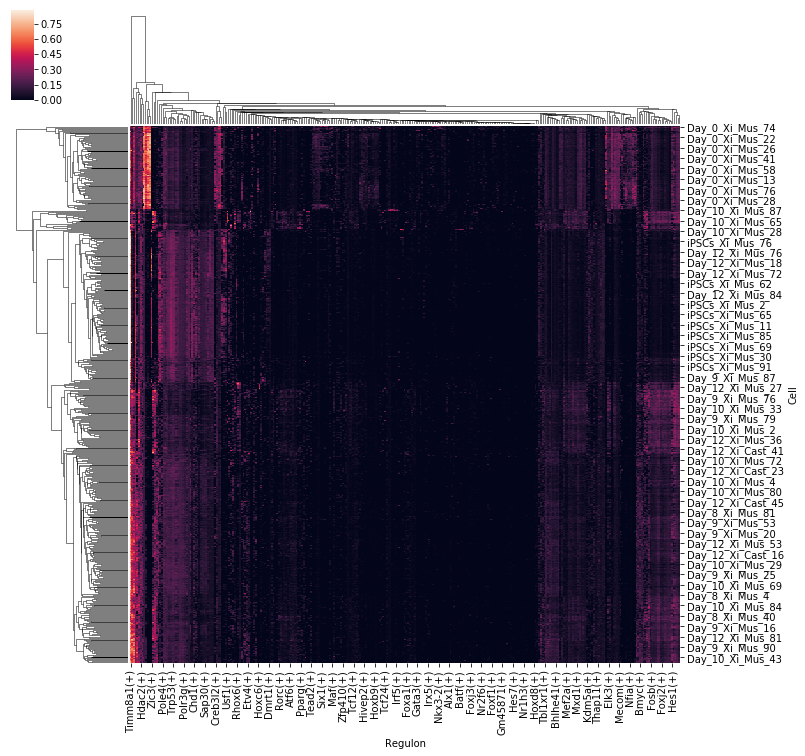

In [19]:
# not used in the paper
sns.clustermap(auc_mtx, figsize=(12,12))

## Create a loom file

This is the code I used to generate the loom file at the moment of running SCENIC analysis.  
However, currently I implemented a better solution - a single function based on the Sara's Aibar functions for nextflow pipeline.  
Available in a separate notebook - look for "creating a loom file.ipynb".

In [73]:
import os
import pandas as pd
from pyscenic.export import export2loom
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons

In [71]:
MOTIFS_FNAME = os.path.join(DATA_FOLDER, "/staging/leuven/stg_00041/Adrian/TALON_JANISZEWSKI_XCR2/SCENIC/motifs_all_5runs.csv")
REGULONS_FNAME = os.path.join(DATA_FOLDER, "/staging/leuven/stg_00041/Adrian/TALON_JANISZEWSKI_XCR2/SCENIC/data_folder/regulons.p") # LOADED IN WORKSPACE

In [72]:
!ls {RESOURCES_FOLDER}

AJ_0065_annotation.csv	       annotation_loom.csv
AJ_0065_counts_clean.csv       mm_mgi_tfs.txt
AJ_0065_seurat_normCounts.csv  motifs-v9-nr.mgi-m0.001-o0.0.tbl
AJ_0065_tSNE_dims.csv


### Load necessary files

### Import count matrix

In [49]:
exp_mtx = pd.read_csv(os.path.join(RESOURCES_FOLDER, "AJ_0065_seurat_normCounts.csv"), index_col=0, sep=',').T

In [25]:
exp_mtx.head()

,Gm37363,Gm19938,Gm37381,Gm6101,Sox17,Gm7357,Gm7369,Gm6085,Gm2053,Gm6123,...,mt-Nd4,mt-Ts2,mt-Tl2,mt-Nd5,mt-Nd6,mt-Te,mt-Cytb,mt-Tt,mt-Tp,pCX-eGFP
Day_9_Xi_Mus_33,0.0,0.0,0.000000,0.02384,0.0,0.0,0.0,0.023840,0.0,0.000000,...,2.287908,0.0,0.0,3.004706,0.961819,0.0,3.277195,0.047124,0.069879,0.0
Day_10_Xi_Mus_25,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,2.269897,0.0,0.0,3.119671,1.072334,0.0,3.499149,0.000000,0.108127,0.0
Day_10_Xi_Mus_32,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.124711,0.0,0.018797,...,1.510558,0.0,0.0,1.661891,0.375273,0.0,3.095562,0.037247,0.018797,0.0
Day_9_Xi_Mus_27,0.0,0.0,0.034501,0.00000,0.0,0.0,0.0,0.034501,0.0,0.000000,...,1.838787,0.0,0.0,2.263015,0.636199,0.0,3.377359,0.131391,0.131391,0.0
Day_9_Xi_Mus_36,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,3.347592,0.0,0.0,3.760602,1.605019,0.0,5.254509,0.097923,0.368667,0.0


Chek if expression matrix has the correct format

In [26]:
def is_valid_exp_matrix(mtx):
    return (all(isinstance(idx, str) for idx in mtx.index) 
            and all(isinstance(idx, str) for idx in mtx.columns)
            and (mtx.index.nlevels == 1)
            and (mtx.columns.nlevels == 1))

In [27]:
is_valid_exp_matrix(exp_mtx)

True

### Import motifs

In [28]:
motifs = df

In [29]:
motifs.head()

Enrichment            \
                                                              NES       AUC   
TF      MotifID                                                               
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234   3.463199  0.056180   
        cisbp__M5866                                     3.209787  0.054438   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1                4.048500  0.060205   
        cisbp__M4451                                     3.539259  0.056703   
        hocomoco__USF1_MOUSE.H11MO.0.A                   3.107152  0.053732   

                                                                              \
                                                       MotifSimilarityQvalue   
TF      MotifID                                                                
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234              0.000205   
        cisbp__M5866                                                0.000127   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1                           0.000007   
        cisbp__M4451                                                0.000233   
        hocomoco__USF1_MOUSE.H11MO.0.A                              0.000675   

                                                                            \
                                                       OrthologousIdentity   
TF      MotifID                                                              
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234            1.000000   
        cisbp__M5866                                              1.000000   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1                         0.905109   
        cisbp__M4451                                              1.000000   
        hocomoco__USF1_MOUSE.H11MO.0.A                            1.000000   

                                                                                                           \
                                                                                               Annotation   
TF      MotifID                                                                                             
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234  gene is annotated for similar motif taipale__B...   
        cisbp__M5866                                    gene is annotated for similar motif cisbp__M59...   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1               gene is orthologous to ENSG00000134107 in H. s...   
        cisbp__M4451                                    motif similar to transfac_pro__M00985 ('V$STRA...   
        hocomoco__USF1_MOUSE.H11MO.0.A                  gene is annotated for similar motif swissregul...   

                                                                                                           \
                                                                                                  Context   
TF      MotifID                                                                                             
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234  (weight>75.0%, mm10__refseq-r80__500bp_up_and_...   
        cisbp__M5866                                    (weight>75.0%, mm10__refseq-r80__500bp_up_and_...   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1               (weight>75.0%, mm10__refseq-r80__500bp_up_and_...   
        cisbp__M4451                                    (weight>75.0%, mm10__refseq-r80__500bp_up_and_...   
        hocomoco__USF1_MOUSE.H11MO.0.A                  (weight>75.0%, mm10__refseq-r80__500bp_up_and_...   

                                                                                                           \
                                                                                              TargetGenes   
TF      MotifID                                                                                             
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234  [(Cnppd1, 0.514658020982605

In [30]:
df = load_motifs("SCENIC/motifs_all_5runs.csv")
regulons = df2regulons(df)

311

In [31]:
regulons[0]

Regulon(name='2410141K09Rik(+)', gene2weight=<frozendict {'Cdk4': 1.9686237590344757, 'Gtf2h1': 5.435089243790327, 'Sae1': 26.1185093795542, 'Qtrt1': 10.440104910079926, 'Apex1': 11.259912237840286, 'Pop1': 26.1185093795542, 'Dvl2': 26.1185093795542, 'Cd3eap': 11.259912237840286, 'H2afz': 4.9819881542185325, 'Ung': 12.274223014430593, 'Hspbap1': 11.259912237840286, 'Igf2bp1': 26.1185093795542, 'Arhgef5': 4.464784629557613, 'Get4': 5.029571048918716, 'Selenoh': 9.851043702787138, 'Cpeb1': 5.38559083646451, 'Gid4': 4.012663886786825, 'Smc3': 2.8263124911109934, 'Eif4e': 5.029571048918716, 'Pnldc1': 4.464784629557613, 'Snx5': 9.893279749357195, 'Ppa1': 4.9819881542185325, 'Adam10': 9.851043702787138, 'Fam178b': 32.02203587799681, 'Maged1': 3.1041497013711457, 'Slc5a6': 6.221151678856874, 'Rpl35a': 12.274223014430593, 'Sgk1': 3.2660128610643353, 'Sap25': 3.0050913927760727, 'Mtch2': 11.619997382679946, 'Mrpl15': 13.403029216443569, 'Mest': 4.012663886786825, 'Ipo13': 12.274223014430593, 'N

#### Import annotation file

In [32]:
annotation_loom = pd.read_csv(os.path.join(RESOURCES_FOLDER, "AJ_0065_annotation.csv"), index_col=0, sep=',')

In [33]:
annotation_loom.head()

,Timepoint,Xi,Cell,GC_index1_index2,Name
Day_9_Xi_Mus_33,Day_9,Mus,33,GC071392_ACTCTAGG-AAGAGGCA,Day_9_Xi_Mus_33
Day_10_Xi_Mus_25,Day_10,Mus,25,GC071392_ACTCTAGG-ACTCGCTA,Day_10_Xi_Mus_25
Day_10_Xi_Mus_32,Day_10,Mus,32,GC071392_ACTCTAGG-ACTGAGCG,Day_10_Xi_Mus_32
Day_9_Xi_Mus_27,Day_9,Mus,27,GC071392_ACTCTAGG-AGGCAGAA,Day_9_Xi_Mus_27
Day_9_Xi_Mus_36,Day_9,Mus,36,GC071392_ACTCTAGG-ATCTCAGG,Day_9_Xi_Mus_36


In [34]:
annotation_loom = annotation_loom.loc[:,"Timepoint"]

In [35]:
annotation_loom.head()

Day_9_Xi_Mus_33      Day_9
Day_10_Xi_Mus_25    Day_10
Day_10_Xi_Mus_32    Day_10
Day_9_Xi_Mus_27      Day_9
Day_9_Xi_Mus_36      Day_9
Name: Timepoint, dtype: object

In [262]:
annotation_loom.to_csv("resources_folder/annotation_loom.csv")

In [36]:
ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "annotation_loom.csv")

In [37]:
!head {ANNOTATIONS_FNAME}

Day_9_Xi_Mus_33,Day_9
Day_10_Xi_Mus_25,Day_10
Day_10_Xi_Mus_32,Day_10
Day_9_Xi_Mus_27,Day_9
Day_9_Xi_Mus_36,Day_9
Day_10_Xi_Mus_30,Day_10
Day_10_Xi_Mus_33,Day_10
Day_9_Xi_Mus_32,Day_9
Day_10_Xi_Mus_34,Day_10
Day_10_Xi_Mus_28,Day_10


In [38]:
with open(ANNOTATIONS_FNAME, "rt") as f:
     annotations = dict(line.strip().replace("\"", "").split(",") for idx, line in enumerate(f) if idx > 0)

Check if annotation mapping has the correct format.

In [39]:
def is_valid_annotation_mapping(m):
    return (all(isinstance(k, str) for k in m.keys()) 
            and all(isinstance(v, str) for v in m.values()))

is_valid_annotation_mapping(annotations)

True

In [40]:
dict(list(annotations.items())[:3])

{'Day_10_Xi_Mus_25': 'Day_10',
 'Day_10_Xi_Mus_32': 'Day_10',
 'Day_9_Xi_Mus_27': 'Day_9'}

### Import embeddings

Create embeddings based on tSNE from Seurat (on normalized expression values)  
Name of columns should be "_X" and "_Y"

In [41]:
embeddings = pd.read_csv(os.path.join(RESOURCES_FOLDER, "AJ_0065_tSNE_dims.csv"), index_col=0, sep=',')
embeddings.head()

,tSNE_1,tSNE_2,Timepoint
Day_9_Xi_Mus_33,-9.225725,-7.434309,Day_9
Day_10_Xi_Mus_25,-9.906587,7.950744,Day_10
Day_10_Xi_Mus_32,-10.664682,0.242444,Day_10
Day_9_Xi_Mus_27,-9.670420,-5.194831,Day_9
Day_9_Xi_Mus_36,-8.247826,-0.142224,Day_9


In [42]:
embeddings = embeddings.iloc[:,[0,1]]
embeddings.columns=['_X', '_Y']
embeddings.head()

,_X,_Y
Day_9_Xi_Mus_33,-9.225725,-7.434309
Day_10_Xi_Mus_25,-9.906587,7.950744
Day_10_Xi_Mus_32,-10.664682,0.242444
Day_9_Xi_Mus_27,-9.670420,-5.194831
Day_9_Xi_Mus_36,-8.247826,-0.142224


In [43]:
embeddings = { "tSNE (default)" : pd.DataFrame(data=embeddings,
                                      index=exp_mtx.index, columns=['_X', '_Y']) } # (n_cells, 2)

In [44]:
embeddings

{'tSNE (default)':                          _X         _Y
 Day_9_Xi_Mus_33   -9.225725  -7.434309
 Day_10_Xi_Mus_25  -9.906587   7.950744
 Day_10_Xi_Mus_32 -10.664682   0.242444
 Day_9_Xi_Mus_27   -9.670420  -5.194831
 Day_9_Xi_Mus_36   -8.247826  -0.142224
 Day_10_Xi_Mus_30   8.634478   7.834693
 Day_10_Xi_Mus_33  -5.695939  -9.170613
 Day_9_Xi_Mus_32   -5.695792  -7.274691
 Day_10_Xi_Mus_34  -5.787895  -7.178159
 Day_10_Xi_Mus_28  10.367212  10.319154
 Day_9_Xi_Mus_26  -11.885176   6.361765
 Day_9_Xi_Mus_31  -14.845065   2.505960
 Day_10_Xi_Mus_27  -5.662548  -2.774302
 Day_9_Xi_Mus_35  -14.663222   6.519214
 Day_9_Xi_Mus_29  -15.990730  -3.109206
 Day_10_Xi_Mus_26 -13.973937  -4.380317
 Day_9_Xi_Mus_25  -11.745904   7.028959
 Day_10_Xi_Mus_29  -5.066755   4.888993
 Day_10_Xi_Mus_31  -7.412264  -0.461196
 Day_9_Xi_Mus_30  -10.783784  -6.207841
 Day_9_Xi_Mus_28  -13.472282   7.098586
 Day_10_Xi_Mus_36 -14.079810   4.121382
 Day_10_Xi_Mus_35  -2.844373   2.483160
 Day_0_Xi_Mus_21    7.

In [46]:
from collections import OrderedDict
id2name = OrderedDict()
embeddings_X = pd.DataFrame(index=exp_mtx.index)
embeddings_Y = pd.DataFrame(index=exp_mtx.index)
for idx, (name, df_embedding) in enumerate(embeddings.items()):
    if(len(df_embedding.columns)!=2):
        raise Exception('The embedding should have two columns.')

In [47]:
embedding_id = idx - 1 # Default embedding must have id == -1 for SCope.
id2name[embedding_id] = name

In [48]:
embedding = df_embedding.copy()
embedding.columns=['_X', '_Y']
embeddings_X = pd.merge(embeddings_X, embedding['_X'].to_frame().rename(columns={'_X': str(embedding_id)}), left_index=True, right_index=True)
embeddings_Y = pd.merge(embeddings_Y, embedding['_Y'].to_frame().rename(columns={'_Y': str(embedding_id)}), left_index=True, right_index=True)

In [49]:
embedding.shape
embedding.head()

,_X,_Y
Day_9_Xi_Mus_33,-9.225725,-7.434309
Day_10_Xi_Mus_25,-9.906587,7.950744
Day_10_Xi_Mus_32,-10.664682,0.242444
Day_9_Xi_Mus_27,-9.670420,-5.194831
Day_9_Xi_Mus_36,-8.247826,-0.142224


### Calculate the number of genes per cell

In [50]:
binary_mtx = exp_mtx.copy()
binary_mtx[binary_mtx != 0] = 1.0
ngenes = binary_mtx.sum(axis=1).astype(int)
ngenes

Day_9_Xi_Mus_33     5432
Day_10_Xi_Mus_25    6164
Day_10_Xi_Mus_32    7421
Day_9_Xi_Mus_27     7877
Day_9_Xi_Mus_36     5914
Day_10_Xi_Mus_30    7492
Day_10_Xi_Mus_33    5652
Day_9_Xi_Mus_32     6254
Day_10_Xi_Mus_34    6293
Day_10_Xi_Mus_28    9498
Day_9_Xi_Mus_26     8378
Day_9_Xi_Mus_31     7250
Day_10_Xi_Mus_27    5258
Day_9_Xi_Mus_35     8005
Day_9_Xi_Mus_29     8543
Day_10_Xi_Mus_26    6816
Day_9_Xi_Mus_25     7842
Day_10_Xi_Mus_29    8154
Day_10_Xi_Mus_31    7016
Day_9_Xi_Mus_30     7618
Day_9_Xi_Mus_28     8235
Day_10_Xi_Mus_36    9053
Day_10_Xi_Mus_35    6287
Day_0_Xi_Mus_21     7080
Day_8_Xi_Mus_13     6792
Day_8_Xi_Mus_20     8263
Day_0_Xi_Mus_15     5649
Day_0_Xi_Mus_24     7910
Day_8_Xi_Mus_18     5832
Day_8_Xi_Mus_21     7517
                    ... 
iPSCs_Xi_Mus_34     9200
iPSCs_Xi_Mus_28     9083
iPSCs_Xi_Mus_27     7750
iPSCs_Xi_Mus_26     8457
iPSCs_Xi_Mus_29     7866
iPSCs_Xi_Mus_31     6714
iPSCs_Xi_Mus_35     7647
iPSCs_Xi_Mus_49     7645
iPSCs_Xi_Mus_56     6044


### Encode genes in regulons as "binary" membership matrix

In [52]:
from operator import attrgetter
genes = np.array(exp_mtx.columns)
n_genes = len(genes)
n_regulons = len(regulons)
data = np.zeros(shape=(n_genes, n_regulons), dtype=int)
for idx, regulon in enumerate(regulons):
    data[:, idx] = np.isin(genes, regulon.genes).astype(int)
regulon_assignment = pd.DataFrame(data=data,
                                    index=exp_mtx.columns,
                                    columns=list(map(attrgetter('name'), regulons)))

In [53]:
regulon_assignment.head()

,2410141K09Rik(+),Akr1a1(+),Alx1(+),Alx3(+),Alx4(+),Arid3a(+),Arnt(+),Atf3(+),Atf4(+),Atf6(+),...,Zfp148(+),Zfp362(+),Zfp410(+),Zfp42(+),Zfp467(+),Zfp667(+),Zic3(+),Zic5(+),Zmiz1(+),Zscan10(+)
Gm37363,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm19938,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm37381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm6101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sox17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Encode cell type clusters.
The name of the column should match the identifier of the clustering.

In [54]:
name2idx = dict(map(reversed, enumerate(sorted(set(annotations.values())))))

In [55]:
name2idx

{'Day_0': 0, 'Day_10': 1, 'Day_12': 2, 'Day_8': 3, 'Day_9': 4, 'iPSCs': 5}

In [56]:
name2idx = {'Day_0': 0, 'Day_8': 1, 'Day_9': 2, 'Day_10': 3, 'Day_12': 4, 'iPSCs': 5}

In [57]:
name2idx

{'Day_0': 0, 'Day_8': 1, 'Day_9': 2, 'Day_10': 3, 'Day_12': 4, 'iPSCs': 5}

Not sure if orders matters, but in case I create new name2idx dict with correct order mapping

In [58]:
clusterings = pd.DataFrame(data=exp_mtx.index.values,
                               index=exp_mtx.index,
                               columns=['0']).replace(annotations).replace(name2idx)

In [59]:
clusterings.head()

,0
Day_9_Xi_Mus_33,Day_9_Xi_Mus_33
Day_10_Xi_Mus_25,3
Day_10_Xi_Mus_32,3
Day_9_Xi_Mus_27,2
Day_9_Xi_Mus_36,2


In [60]:
clusterings.iloc[[0],[0]] = 2

In [61]:
clusterings.head()

,0
Day_9_Xi_Mus_33,2
Day_10_Xi_Mus_25,3
Day_10_Xi_Mus_32,3
Day_9_Xi_Mus_27,2
Day_9_Xi_Mus_36,2


### Create meta-data structure

In [62]:
def create_structure_array(df):
    return np.array([tuple(row) for row in df.values],
                    dtype=np.dtype(list(zip(df.columns, df.dtypes))))

In [63]:
    default_embedding = next(iter(embeddings.values())).copy()
    default_embedding.columns=['_X', '_Y']
    column_attrs = {
        "CellID": exp_mtx.index.values.astype('str'),
        "nGene": ngenes.values,
        "Embedding": create_structure_array(default_embedding),
        "RegulonsAUC": create_structure_array(auc_mtx),
        "Clusterings": create_structure_array(clusterings),
        "ClusterID": clusterings.values,
        'Embeddings_X': create_structure_array(embeddings_X),
        'Embeddings_Y': create_structure_array(embeddings_Y),
        }
    row_attrs = {
        "Gene": exp_mtx.columns.values.astype('str'),
        "Regulons": create_structure_array(regulon_assignment),
        }

In [64]:
def fetch_logo(context):
    for elem in context:
        if elem.endswith('.png'):
            return elem
    return ""

In [65]:
def fetch_logo(context):
    for elem in context:
        if elem.endswith('.png'):
            return elem
    return ""
name2logo = {reg.name: fetch_logo(reg.context) for reg in regulons}
regulon_thresholds = [{"regulon": name,
                        "defaultThresholdValue":(threshold if isinstance(threshold, float) else threshold[0]),
                        "defaultThresholdName": "guassian_mixture_split",
                        "allThresholds": {"guassian_mixture_split": (threshold if isinstance(threshold, float) else threshold[0])},
                        "motifData": name2logo.get(name, "")} for name, threshold in auc_mtx.iteritems()] #had to change auc_threshold to mtx, dunno why...

In [69]:
import json
general_attrs = {
    "title": "XCR",
    "MetaData": json.dumps({
        "embeddings": [{'id': identifier, 'name': name} for identifier, name in id2name.items()],
        "annotations": [{
            "name": "",
            "values": []
        }],
        "clusterings": [{
            "id": 0,
            "group": "celltype",
            "name": "Cell Type",
            "clusters": [{"id": idx, "description": name} for name, idx in name2idx.items()]
        }],
        "regulonThresholds": regulon_thresholds
    }),
    "Genome": "mm10"}

### Add tree structure
All three levels need to be supplied

In [86]:
tree_structure: Sequence[str] = ()

AttributeError: module 'itertools' has no attribute 'Sequence'

In [85]:
from itertools import islice
import itertools
assert len(tree_structure) <= 3, ""
general_attrs.update(("SCopeTreeL{}".format(idx+1), category)
                        for idx, category in enumerate(list(islice(itertools.chain(tree_structure, itertools.repeat("")), 3))))

In [87]:
def compress_encode(value):
    '''
    Compress using ZLIB algorithm and encode the given value in base64.
    Taken from: https://github.com/aertslab/SCopeLoomPy/blob/5438da52c4bcf48f483a1cf378b1eaa788adefcb/src/scopeloompy/utils/__init__.py#L7
    '''
    return base64.b64encode(zlib.compress(value.encode('ascii'))).decode('ascii')

In [90]:
import base64
import zlib
general_attrs["MetaData"] = compress_encode(value=general_attrs["MetaData"])

In [128]:
from pyscenic.genesig import Regulon

In [92]:
import loompy as lp
lp.create(filename="SCENIC/loom_XCR_5runs.loom",
              layers=exp_mtx.T.values,
              row_attrs=row_attrs,
              col_attrs=column_attrs,
              file_attrs=general_attrs)

## Calculate the number of targets of regulon at specific chromosome 

#### Extract target genes of each regulono

In [11]:
targets = load_motifs("SCENIC/motifs_all_5runs.csv")

In [12]:
targets.head()

Enrichment            \
                                                              NES       AUC   
TF      MotifID                                                               
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234   3.463199  0.056180   
        cisbp__M5866                                     3.209787  0.054438   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1                4.048500  0.060205   
        cisbp__M4451                                     3.539259  0.056703   
        hocomoco__USF1_MOUSE.H11MO.0.A                   3.107152  0.053732   

                                                                              \
                                                       MotifSimilarityQvalue   
TF      MotifID                                                                
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234              0.000205   
        cisbp__M5866                                                0.000127   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1                           0.000007   
        cisbp__M4451                                                0.000233   
        hocomoco__USF1_MOUSE.H11MO.0.A                              0.000675   

                                                                            \
                                                       OrthologousIdentity   
TF      MotifID                                                              
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234            1.000000   
        cisbp__M5866                                              1.000000   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1                         0.905109   
        cisbp__M4451                                              1.000000   
        hocomoco__USF1_MOUSE.H11MO.0.A                            1.000000   

                                                                                                           \
                                                                                               Annotation   
TF      MotifID                                                                                             
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234  gene is annotated for similar motif taipale__B...   
        cisbp__M5866                                    gene is annotated for similar motif cisbp__M59...   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1               gene is orthologous to ENSG00000134107 in H. s...   
        cisbp__M4451                                    motif similar to transfac_pro__M00985 ('V$STRA...   
        hocomoco__USF1_MOUSE.H11MO.0.A                  gene is annotated for similar motif swissregul...   

                                                                                                           \
                                                                                                  Context   
TF      MotifID                                                                                             
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234  (activating, mm10__refseq-r80__500bp_up_and_10...   
        cisbp__M5866                                    (activating, mm10__refseq-r80__500bp_up_and_10...   
        dbcorrdb__ZEB1__ENCSR000BND_1__m1               (activating, mm10__refseq-r80__500bp_up_and_10...   
        cisbp__M4451                                    (activating, mm10__refseq-r80__500bp_up_and_10...   
        hocomoco__USF1_MOUSE.H11MO.0.A                  (activating, mm10__refseq-r80__500bp_up_and_10...   

                                                                                                           \
                                                                                              TargetGenes   
TF      MotifID                                                                                             
Bhlhe40 flyfactorsurvey__HLH106_SANGER_5_2_FBgn0015234  [(Cnppd1, 0.514658020982605

In [13]:
targets_regulons = df2regulons(targets)

### Collect regulons with corresponding target genes in a list

In [14]:
regulon_genes = []

for tf in range(len(targets_regulons)):
    tf_targets = [targets_regulons[tf].name, list(targets_regulons[tf].gene2weight)] # Making a list where first element is TF second is list of targets
    regulon_genes.append(tf_targets)

In [15]:
print(regulon_genes[1])

['Akr1a1(+)', ['S100a4', 'Rbms3', 'Col1a1', 'Tmem119', 'Myl6', 'Col1a2', 'Selenom', 'Lgals1', 'Wls', 'Actb', 'Lox']]


In [16]:
regulon_genes_df = pd.DataFrame(regulon_genes, columns=['Regulon', 'Targets'])

In [16]:
regulon_genes_df.head()

,Regulon,Targets
0,2410141K09Rik(+),"[Cdk4, Gtf2h1, Sae1, Qtrt1, Apex1, Pop1, Dvl2,..."
1,Akr1a1(+),"[S100a4, Rbms3, Col1a1, Tmem119, Myl6, Col1a2,..."
2,Alx1(+),"[Tox, Igf2, Egr3, Cnn1, Hoxc8, Hoxa3, Hoxa5, S..."
3,Alx3(+),"[Snai3, Dlx2, Alx3, Nr4a3, Prr5, Kif1c, Dkk2, ..."
4,Alx4(+),"[Lingo1, Klhl28, Plagl2, Cttnbp2, Hfm1, Rapgef..."


In [17]:
#regulon_genes_df = regulon_genes_df.explode('Targets') # This will work only with Pandas 0.25. In this env 0.23

In [18]:
lst_col = 'Targets'

regulon_genes_df_long = pd.DataFrame({
      col:np.repeat(regulon_genes_df[col].values, regulon_genes_df[lst_col].str.len())
      for col in regulon_genes_df.columns.drop(lst_col)}
    ).assign(**{lst_col:np.concatenate(regulon_genes_df[lst_col].values)})[regulon_genes_df.columns]

In [19]:
regulon_genes_df_long.head()

,Regulon,Targets
0,2410141K09Rik(+),Cdk4
1,2410141K09Rik(+),Gtf2h1
2,2410141K09Rik(+),Sae1
3,2410141K09Rik(+),Qtrt1
4,2410141K09Rik(+),Apex1


In [20]:
regulon_genes_df_long.to_csv("SCENIC/regulons_targets.csv")
#regulon_genes_df_long = pd.read_csv("SCENIC/regulons_targets.csv", index_col = 0)

In [21]:
regulon_genes_df_long

,Regulon,Targets
0,2410141K09Rik(+),Cdk4
1,2410141K09Rik(+),Gtf2h1
2,2410141K09Rik(+),Sae1
3,2410141K09Rik(+),Qtrt1
4,2410141K09Rik(+),Apex1
5,2410141K09Rik(+),Pop1
6,2410141K09Rik(+),Dvl2
7,2410141K09Rik(+),Cd3eap
8,2410141K09Rik(+),H2afz
9,2410141K09Rik(+),Ung


Import chr_gene mapping

In [23]:
chr_gene_map = pd.read_csv("/staging/leuven/stg_00041/Adrian/TALON_JANISZEWSKI_XCR2/SCENIC/resources_folder/chr_gene_mapping.csv", index_col = 0)

In [24]:
chr_gene_map.head()

,Chr,Geneid
1,chr1,4933401J01Rik
2,chr1,Gm26206
3,chr1,Xkr4
4,chr1,Gm18956
5,chr1,Gm37180


In [25]:
# number of genes per chromosome 

chr_no_genes = chr_gene_map.groupby("Chr").count()

In [26]:
chr_gene_map = chr_gene_map.rename(columns={"Geneid": "Targets"})

In [27]:
regulon_genes_chr = pd.merge(regulon_genes_df_long, chr_gene_map,
                            how='left', on = 'Targets')

In [28]:
regulon_genes_chr.head()

,Regulon,Targets,Chr
0,2410141K09Rik(+),Cdk4,chr10
1,2410141K09Rik(+),Gtf2h1,chr7
2,2410141K09Rik(+),Sae1,chr7
3,2410141K09Rik(+),Qtrt1,chr9
4,2410141K09Rik(+),Apex1,chr14


In [29]:
regulon_genes_chr_grouped = regulon_genes_chr.groupby(by = ['Regulon','Chr']).size().reset_index()
regulon_genes_chr_grouped = regulon_genes_chr_grouped.rename(columns={0: "n_targets"})

In [30]:
regulon_genes_chr_grouped.head()

,Regulon,Chr,n_targets
0,2410141K09Rik(+),chr1,5
1,2410141K09Rik(+),chr10,8
2,2410141K09Rik(+),chr11,8
3,2410141K09Rik(+),chr13,1
4,2410141K09Rik(+),chr14,2


### Display ranking of regulons targetting each chromosome

In [35]:
### Define function that plots the ranking per chromosome

def plotRegRank (chr, topnumber = 20) :
    
    chr_top20 = regulon_genes_chr_grouped[regulon_genes_chr_grouped['Chr'] == chr]

    chr_top20 = chr_top20.sort_values('n_targets', ascending=True).tail(n = topnumber)
    chr_top5_value = chr_top20.sort_values('n_targets', ascending=True).tail(n = 6).n_targets.iloc[0]
    
    chr_top20['colors'] = ['red' if x > chr_top5_value else 'darkgreen' for x in chr_top20['n_targets']]

    pp = plt.figure(figsize=(4,6), dpi= 100)
    plt.scatter(chr_top20.n_targets, chr_top20.Regulon, s=150, alpha=.6, color=chr_top20.colors)

    plt.title('Number of {} targets per Regulon'.format(chr), fontdict={'size':12})
    plt.xlabel('Number of {} targets'.format(chr))
    plt.grid(linestyle='--', alpha=0.5)

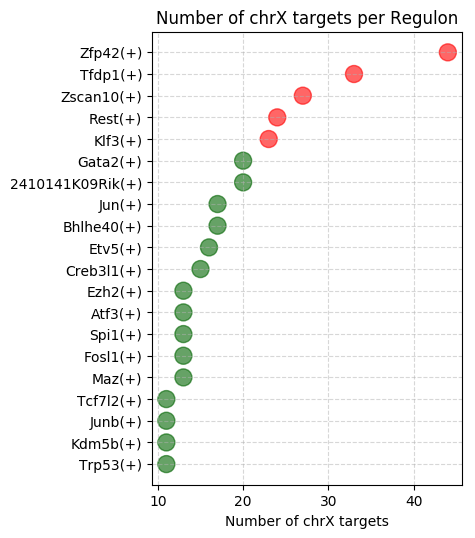

In [34]:
plotRegRank(chr = 'chrX')

In [41]:
from matplotlib.backends.backend_pdf import PdfPages

In [42]:
%%capture 

pp = PdfPages('SCENIC/Regulons_ntargets_all_Chr.pdf') # Initialize output pdf file

pp.savefig(plotRegRank(chr = 'chrX'),bbox_inches='tight')
for i in range(1,20) :
    chr = 'chr{}'.format(i)
    pp.savefig(plotRegRank(chr = chr),bbox_inches='tight')
pp.close() # close multipage pdf object    

### Define regulons that target highest number of genes on all chromosomes

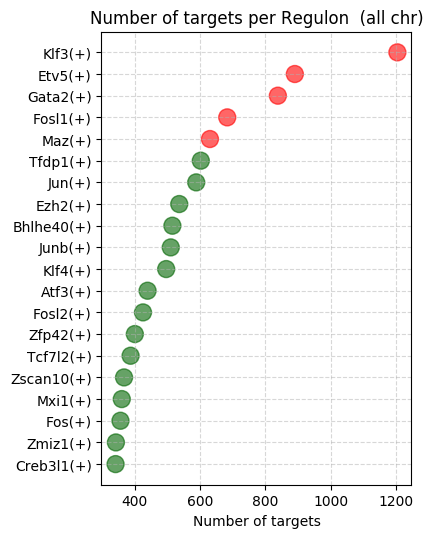

In [211]:
all_top20 =  regulon_genes_chr_grouped.groupby(by = ['Regulon']).agg(np.sum).reset_index()

all_top20 = all_top20.sort_values('n_targets', ascending=True).tail(20)
all_top5_value = all_top20.sort_values('n_targets', ascending=True).tail(n = 6).n_targets.iloc[0]
    
all_top20['colors'] = ['red' if x > all_top5_value else 'darkgreen' for x in all_top20['n_targets']]

pp1 = plt.figure(figsize=(4,6), dpi= 100)
plt.scatter(all_top20.n_targets, all_top20.Regulon, s=150, alpha=.6, color=all_top20.colors)

plt.title('Number of targets per Regulon  (all chr)', fontdict={'size':12})
plt.xlabel('Number of targets')
plt.grid(linestyle='--', alpha=0.5)

In [213]:
pp1.savefig('SCENIC/Number of targets per regulon(allchr).pdf',bbox_inches='tight')

### Define regulons that target highest number of genes on all autosomes

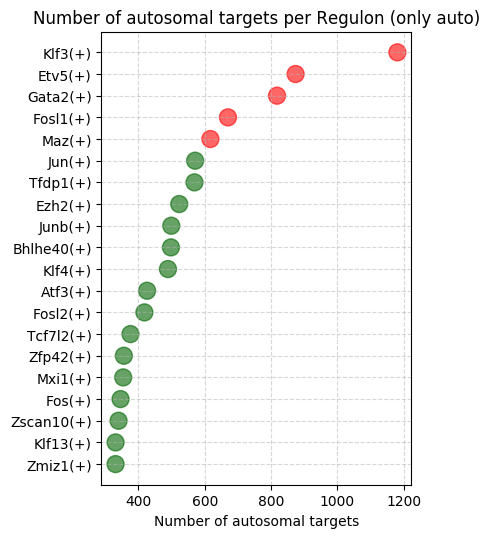

In [214]:
auto_top20 =  regulon_genes_chr_grouped[regulon_genes_chr_grouped['Chr'] != 'chrX'].groupby(by = ['Regulon']).agg(np.sum).reset_index()

auto_top20 = auto_top20.sort_values('n_targets', ascending=True).tail(20)
auto_top5_value = auto_top20.sort_values('n_targets', ascending=True).tail(n = 6).n_targets.iloc[0]
    
auto_top20['colors'] = ['red' if x > auto_top5_value else 'darkgreen' for x in auto_top20['n_targets']]

pp2 = plt.figure(figsize=(4,6), dpi= 100)
plt.scatter(auto_top20.n_targets, auto_top20.Regulon, s=150, alpha=.6, color=auto_top20.colors)

plt.title('Number of autosomal targets per Regulon (only auto)', fontdict={'size':12})
plt.xlabel('Number of autosomal targets')
plt.grid(linestyle='--', alpha=0.5)

In [215]:
pp2.savefig('SCENIC/Number of targets per regulon(allauto).pdf',bbox_inches='tight')

### Compare the number of regulon targets between all chromosomes

In [18]:
Zfp42_perChr = regulon_genes_chr_grouped[regulon_genes_chr_grouped['Regulon'] == 'Zfp42(+)'].sort_values('n_targets', ascending=True)
Zfp42_perChr

,Regulon,Chr,n_targets
3742,Zfp42(+),chr18,10
3736,Zfp42(+),chr12,11
3734,Zfp42(+),chr10,12
3751,Zfp42(+),chr9,12
3743,Zfp42(+),chr19,12
3740,Zfp42(+),chr16,13
3737,Zfp42(+),chr13,15
3750,Zfp42(+),chr8,17
3738,Zfp42(+),chr14,17
3747,Zfp42(+),chr5,17


In [19]:
Zfp42_perChr_norm = pd.merge(Zfp42_perChr, chr_no_genes, how="left", on="Chr")

In [20]:
Zfp42_perChr_norm["n_targets_norm"] = (Zfp42_perChr_norm["n_targets"]/Zfp42_perChr_norm["Geneid"])*100

In [22]:
Zfp42_perChr_norm
Zfp42_perChr_norm.to_csv("Zfp42_target_numbers.csv")

Text(0.5, 1.0, 'Number of Zfp42 targets across chromosomes')

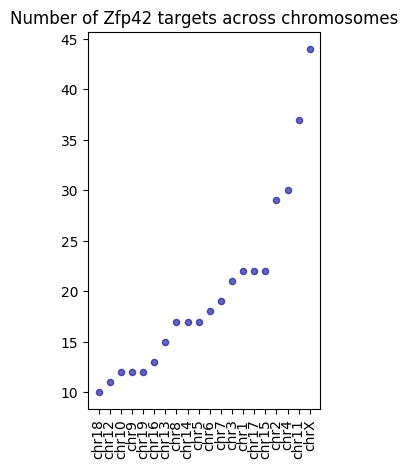

In [219]:
pp3 = plt.figure(figsize=(3,5), dpi= 100)
plt.scatter(Zfp42_perChr.Chr, Zfp42_perChr.n_targets, s=20, alpha=.6, color='darkblue')
plt.xticks(rotation=90)
plt.title('Number of Zfp42 targets across chromosomes', fontdict={'size':12})

In [220]:
pp3.savefig('Number of Zfp42 targets across chromosomes.pdf',bbox_inches='tight')

## Test if the number of targets correlate with number of genes on the chromosome

In [230]:
chr_gene_map1 = chr_gene_map.rename(columns={"Targets": "Gene"})
chr_gene_map.head()

,Chr,Targets
0,chr1,4933401J01Rik
1,chr1,Gm26206
2,chr1,Xkr4
3,chr1,Gm18956
4,chr1,Gm37180


In [231]:
chr_gene_count = chr_gene_map1.groupby(by = ['Chr']).count().reset_index()
chr_gene_count.head()

,Chr,Gene
0,chr1,3433
1,chr10,2621
2,chr11,3002
3,chr12,2455
4,chr13,2497


In [234]:
regulon_genes_chr = pd.merge(chr_gene_count, Zfp42_perChr,
                            how='left', on = 'Chr')
regulon_genes_chr.tail()

,Chr,Gene,Regulon,n_targets
18,chr9,2851,Zfp42(+),12.0
19,chrM,37,NaN,NaN
20,chrX,2613,Zfp42(+),44.0
21,chrY,1570,NaN,NaN
22,egfp,1,NaN,NaN


In [246]:
regulon_genes_chr = regulon_genes_chr.dropna()
regulon_genes_chr.tail()

,Chr,Gene,Regulon,n_targets
15,chr6,3127,Zfp42(+),18.0
16,chr7,4709,Zfp42(+),19.0
17,chr8,2533,Zfp42(+),17.0
18,chr9,2851,Zfp42(+),12.0
20,chrX,2613,Zfp42(+),44.0


Text(0, 0.5, 'Number of Zfp42 targets on chromosome')

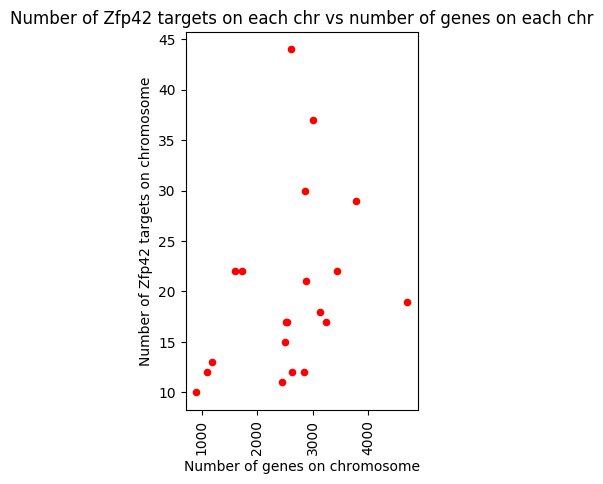

In [264]:
pp4 = plt.figure(figsize=(3,5), dpi= 100)
plt.scatter(regulon_genes_chr.Gene, regulon_genes_chr.n_targets, s=20, color = 'red')
plt.xticks(rotation=90)
plt.title('Number of Zfp42 targets on each chr vs number of genes on each chr', fontdict={'size':12})
plt.xlabel('Number of genes on chromosome')
plt.ylabel('Number of Zfp42 targets on chromosome')

In [243]:
from scipy.stats import pearsonr

In [261]:
bin_values = np.arange(start=0, stop=50, step=1)

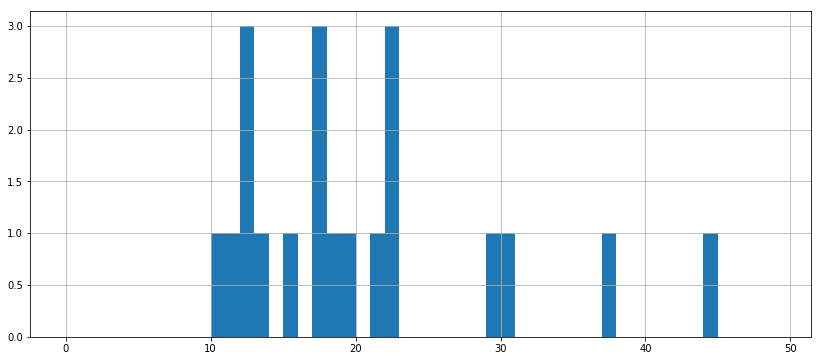

In [262]:
regulon_genes_chr['n_targets'].hist(bins=bin_values, figsize=[14,6])

In [248]:
corr, _ = pearsonr(regulon_genes_chr.Gene, regulon_genes_chr.n_targets)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.329
